# TCC TimeSeries Classification

In [1]:
# !pip install pandas numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

tqdm.pandas()


/home/jedi/.python-venv/timeseries/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the data

In [2]:
# !pip install openpyxl
df = pd.read_excel("./datasets/24PI109.xlsx", sheet_name="Medições")

# index dataframe
df.set_index("DATE", inplace=True)

df


,COTA,MCA,PROF_NA
DATE,,,
2019-01-01,881.231000,14.140000,18.030000
2019-01-02,881.241000,14.140000,18.030000
2019-01-03,881.241000,14.140000,18.030000
2019-01-04,881.241000,14.140000,18.030000
2019-01-05,881.240000,14.139000,18.031000
...,...,...,...
2022-05-31,883.336585,16.235585,15.934415
2022-06-01,883.322128,16.221128,15.948872
2022-06-02,883.316206,16.215206,15.954794


## Data Preprocessing

### Inserting missing rows

In [3]:
# inserting missing day rows in dataframe
df = df.asfreq('D', fill_value=np.nan)

df


,COTA,MCA,PROF_NA
DATE,,,
2019-01-01,881.231000,14.140000,18.030000
2019-01-02,881.241000,14.140000,18.030000
2019-01-03,881.241000,14.140000,18.030000
2019-01-04,881.241000,14.140000,18.030000
2019-01-05,881.240000,14.139000,18.031000
...,...,...,...
2022-05-31,883.336585,16.235585,15.934415
2022-06-01,883.322128,16.221128,15.948872
2022-06-02,883.316206,16.215206,15.954794


### Interpolating the missing values

In [4]:
df = df.interpolate()

df.notna().sum()


COTA       1251
MCA        1251
PROF_NA    1251
dtype: int64

## X and no y

In [5]:
# X = df[["DATE", "MCA"]]


## Forecasting Model

### Matrix profiling

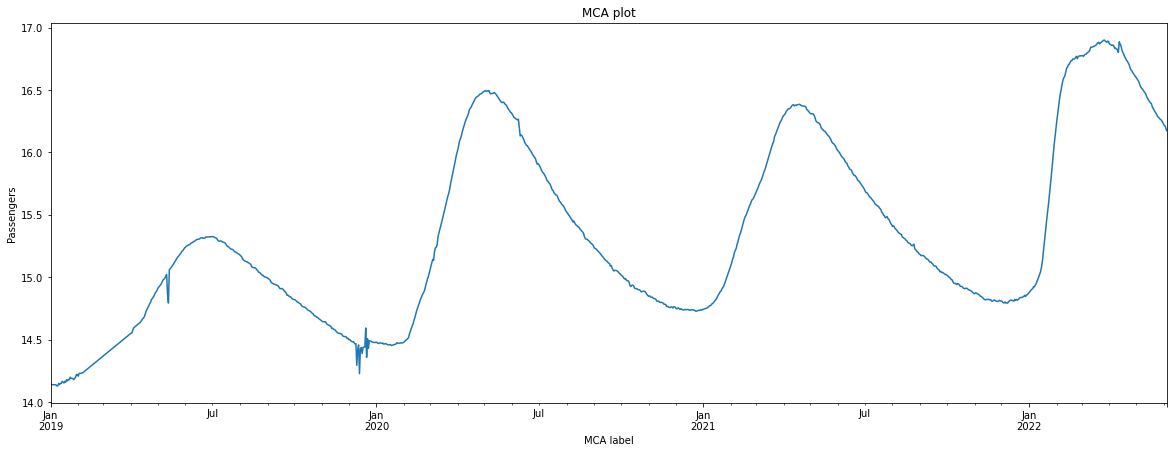

In [6]:

df[["MCA"]].plot(figsize=(20,7), legend=None, title='MCA plot')
plt.xlabel('MCA label')
plt.ylabel('Passengers')
plt.show()


In [7]:
import matrixprofile as mp

windows = [
    ('1 Month', 30),
    ('2 Months', 2 * 30),
    ('3 Months', 3 * 30),
    ('4 Months', 4 * 30),
    ('5 Months', 5 * 30),
    ('6 Months', 6 * 30),
    ('1 Year', 12 * 30),
]

profiles = {}

for label, window_size in windows:
    profile = mp.compute(df['MCA'].values, window_size)
    key = '{} Profile'.format(label)
    profiles[key] = profile
    

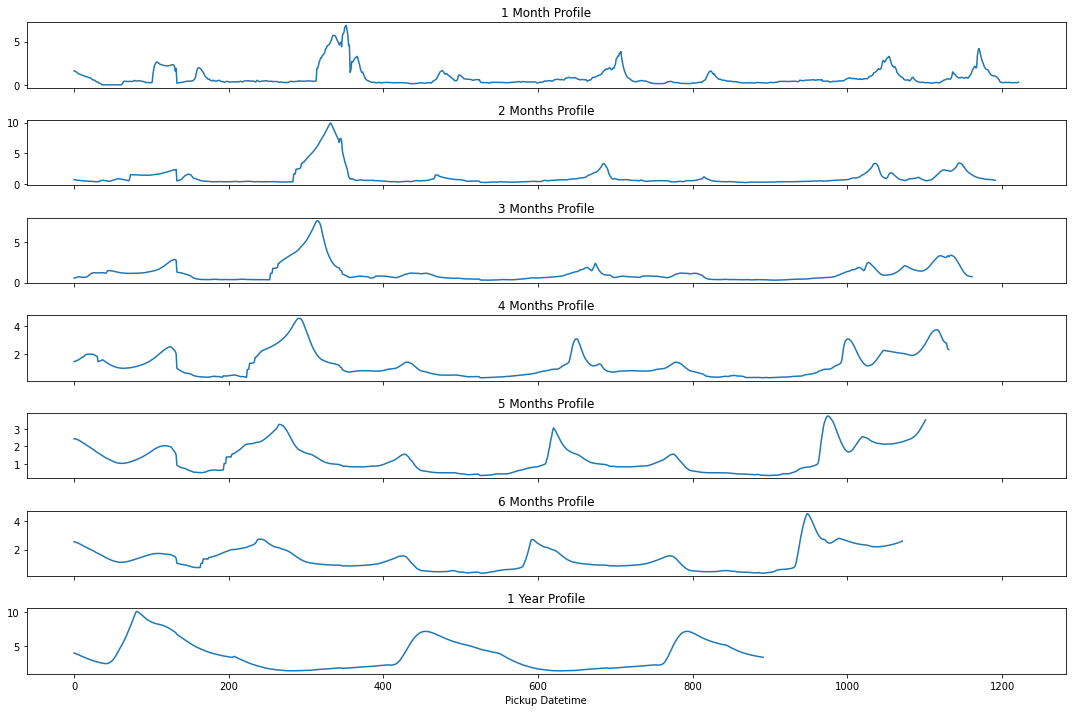

In [8]:
#Plot the signal data
fig, axes = plt.subplots(7,1,sharex=True,figsize=(15,10))

for ax_idx, window in enumerate(windows):
    key = '{} Profile'.format(window[0])
    profile = profiles[key]
    axes[ax_idx].plot(profile['mp'])
    axes[ax_idx].set_title(key)

plt.xlabel('Pickup Datetime')
plt.tight_layout()
plt.show()


## Converting to TimeSeries windows

In [9]:

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
 
data = series_to_supervised(df["MCA"].values, 60)
data


,var1(t-60),var1(t-59),var1(t-58),var1(t-57),var1(t-56),var1(t-55),var1(t-54),var1(t-53),var1(t-52),var1(t-51),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
60,14.140000,14.140000,14.140000,14.140000,14.139000,14.139000,14.139000,14.130000,14.130000,14.150000,...,14.322905,14.328765,14.334626,14.340486,14.346346,14.352207,14.358067,14.363927,14.369788,14.375648
61,14.140000,14.140000,14.140000,14.139000,14.139000,14.139000,14.130000,14.130000,14.150000,14.140000,...,14.328765,14.334626,14.340486,14.346346,14.352207,14.358067,14.363927,14.369788,14.375648,14.381508
62,14.140000,14.140000,14.139000,14.139000,14.139000,14.130000,14.130000,14.150000,14.140000,14.150000,...,14.334626,14.340486,14.346346,14.352207,14.358067,14.363927,14.369788,14.375648,14.381508,14.387369
63,14.140000,14.139000,14.139000,14.139000,14.130000,14.130000,14.150000,14.140000,14.150000,14.150000,...,14.340486,14.346346,14.352207,14.358067,14.363927,14.369788,14.375648,14.381508,14.387369,14.393229
64,14.139000,14.139000,14.139000,14.130000,14.130000,14.150000,14.140000,14.150000,14.150000,14.167000,...,14.346346,14.352207,14.358067,14.363927,14.369788,14.375648,14.381508,14.387369,14.393229,14.399089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1246,16.869675,16.865809,16.860563,16.856326,16.861373,16.851177,16.833739,16.836820,16.826604,16.826052,...,16.326872,16.315001,16.303404,16.286563,16.282793,16.274138,16.264751,16.260609,16.249841,16.235585
1247,16.865809,16.860563,16.856326,16.861373,16.851177,16.833739,16.836820,16.826604,16.826052,16.802252,...,16.315001,16.303404,16.286563,16.282793,16.274138,16.264751,16.260609,16.249841,16.235585,16.221128
1248,16.860563,16.856326,16.861373,16.851177,16.833739,16.836820,16.826604,16.826052,16.802252,16.887069,...,16.303404,16.286563,16.282793,16.274138,16.264751,16.260609,16.249841,16.235585,16.221128,16.215206
1249,16.856326,16.861373,16.851177,16.833739,16.836820,16.826604,16.826052,16.802252,16.887069,16.867621,...,16.286563,16.282793,16.274138,16.264751,16.260609,16.249841,16.235585,16.221128,16.215206,16.199592


In [10]:
# add a column to the dataframe
data = data.assign(target=0)

data

,var1(t-60),var1(t-59),var1(t-58),var1(t-57),var1(t-56),var1(t-55),var1(t-54),var1(t-53),var1(t-52),var1(t-51),...,var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),target
60,14.140000,14.140000,14.140000,14.140000,14.139000,14.139000,14.139000,14.130000,14.130000,14.150000,...,14.328765,14.334626,14.340486,14.346346,14.352207,14.358067,14.363927,14.369788,14.375648,0
61,14.140000,14.140000,14.140000,14.139000,14.139000,14.139000,14.130000,14.130000,14.150000,14.140000,...,14.334626,14.340486,14.346346,14.352207,14.358067,14.363927,14.369788,14.375648,14.381508,0
62,14.140000,14.140000,14.139000,14.139000,14.139000,14.130000,14.130000,14.150000,14.140000,14.150000,...,14.340486,14.346346,14.352207,14.358067,14.363927,14.369788,14.375648,14.381508,14.387369,0
63,14.140000,14.139000,14.139000,14.139000,14.130000,14.130000,14.150000,14.140000,14.150000,14.150000,...,14.346346,14.352207,14.358067,14.363927,14.369788,14.375648,14.381508,14.387369,14.393229,0
64,14.139000,14.139000,14.139000,14.130000,14.130000,14.150000,14.140000,14.150000,14.150000,14.167000,...,14.352207,14.358067,14.363927,14.369788,14.375648,14.381508,14.387369,14.393229,14.399089,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1246,16.869675,16.865809,16.860563,16.856326,16.861373,16.851177,16.833739,16.836820,16.826604,16.826052,...,16.315001,16.303404,16.286563,16.282793,16.274138,16.264751,16.260609,16.249841,16.235585,0
1247,16.865809,16.860563,16.856326,16.861373,16.851177,16.833739,16.836820,16.826604,16.826052,16.802252,...,16.303404,16.286563,16.282793,16.274138,16.264751,16.260609,16.249841,16.235585,16.221128,0
1248,16.860563,16.856326,16.861373,16.851177,16.833739,16.836820,16.826604,16.826052,16.802252,16.887069,...,16.286563,16.282793,16.274138,16.264751,16.260609,16.249841,16.235585,16.221128,16.215206,0
1249,16.856326,16.861373,16.851177,16.833739,16.836820,16.826604,16.826052,16.802252,16.887069,16.867621,...,16.282793,16.274138,16.264751,16.260609,16.249841,16.235585,16.221128,16.215206,16.199592,0


In [11]:
X = data.drop(columns=['target'])
y = data['target']

data = data.sample(frac=1)


In [12]:
# y


In [13]:
# sequences = []

# for i, row in df.iterrows():
#     sequences.append((row, y_train.iloc[i]))


In [14]:
# # param grid for pytorch lstm
# param_grid = {
#     'batch_size': [32, 64, 128],
#     'epochs': [10, 20, 30],
#     'lr': [0.001, 0.01, 0.1],
#     'momentum': [0.9, 0.95, 0.99],
#     'hidden_dim': [10, 20, 30],
#     'num_layers': [1, 2, 3],
#     'bidirectional': [True, False],
#     'dropout': [0.0, 0.1, 0.2],
#     'rnn_type': ['LSTM', 'GRU', 'RNN']
# }

# sequences = [[], []]

# cv = GroupShuffleSplit().split(train_sequences[:,], train_sequences[,:])

# RandomizedSearchCV(lstm, param_grid, cv=cv)



In [15]:
# # sample data
# seq = [([0, 1, 2], 0.1), ([0, 1, 2], 0.1), ([0, 1, 2], 0.1), ([0, 1, 2], 0.1), ([0, 1, 2], 0.1)]

# # get all first values of array of tuples
# seq_x = [x[0] for x in seq]

# seq_y = [x[1] for x in seq]

# seq_x, seq_y


In [52]:
X = df["MCA"]


In [135]:
from sklearn.preprocessing import MinMaxScaler

def get_difference(window_values):

    x = window_values.values[:-1]
    y = window_values.values[-1:][0]

    aggregated = 0
    # for every value in x
    for x_value in x:
        aggregated += abs(y - x_value)

    return aggregated

# descale data

normalized_df = (X - X.min()) / (X.max()-X.min())

mean_values = df["MCA"].rolling(window=16).agg(get_difference)

mean_values = mean_values.dropna()

#mean_values_normalized = (mean_values - mean_values.min()) / (mean_values.max()-mean_values.min())

# display(normalized_df)


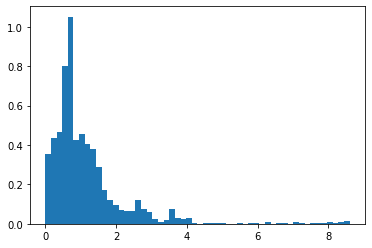

In [178]:
bins = np.linspace(0, mean_values.max(), 55)
# plot of probability density distribution from a list of values normalized
plt.hist(mean_values, bins=bins, density=True, stacked=True)
plt.show()


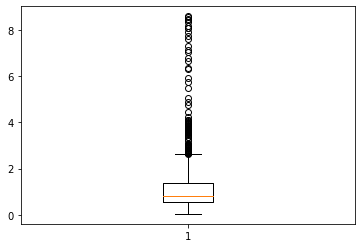

In [174]:
# box plot
plt.boxplot(mean_values)
plt.show()


In [137]:
# sum all nan values
mean_values.isna().sum()


0

In [185]:
bins = np.linspace(0, mean_values.max(), 10)
hist, bin_edges = np.histogram(mean_values, density=True, bins=bins)

hist.sum() / len(hist)


0.11624974470986056

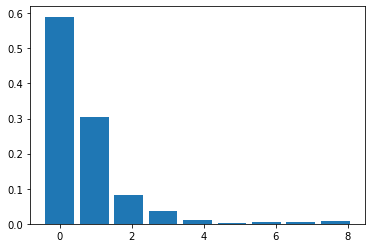

In [188]:

# plot bins
plt.bar(bin_edges[:-1], hist)
plt.show()


In [ ]:
# df_pred = pd.DataFrame({pred: [], real: []})

# df_pred.to_csv("predictions.csv")


In [190]:
df_pred = pd.read_csv("./datasets/pred_1.csv")
df_pred.head()


,pred,real
0,10.592474,11.041099
1,10.659647,11.088406
2,10.727979,11.119944
3,10.788548,11.139655
4,10.832524,11.159367


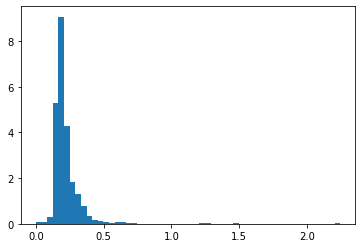

In [200]:

values = df_pred.apply(lambda x: abs(x["pred"] - x["real"]), axis=1)

bins = np.linspace(0, values.max(), 55)
# plot of probability density distribution from a list of values normalized
plt.hist(values, bins=bins, density=True, stacked=True)
plt.show()
